# KTP Waveguide dispersion

This example shows how to sweep the dispersion of a generic waveguide. To do this we need to feed the solver some dispersion as a function of 
 $\lambda$ using smelmers equation. 
 
The constants for the equation can be found here:
http://www.unitedcrystals.com/KTPProp.html

Remember KTP has a different refractive index for each axis which needs to be passed to the solver.

In [77]:
def refractive(lam):
    
    n_square = [ 3.0065 + 0.03901 / (lam**2 - 0.04251) - 0.01327 * lam**2 , 
                 3.0333 + 0.04154 / (lam**2 - 0.04547) - 0.01408 * lam**2 , 
                 3.0065 + 0.05694 / (lam**2 - 0.05658) - 0.01682 * lam**2   ]
    
    index = [ns**0.5 for ns in n_square]
    return index

## Build geometry
To build the geometry you can use your choice of graphics library (or just brute force it): this example uses pillow.   


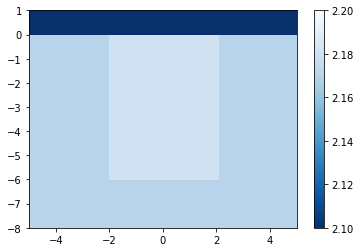

In [78]:
%matplotlib inline

import philsol as ps
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
from matplotlib import cm 
from PIL import Image, ImageDraw


# We define the size of the simulation window (note there is automatically a conductive boundry layer).
simulation_width = 10.
simulation_height = 9. 

# Number of pixels/fd grid points. 
num_x = 81
num_y = 101
dx = simulation_width / float(num_x - 1)
dy = simulation_height / float(num_y - 1)

# Wavelength of end point
lam = .3
k = 2 * cst.pi / lam 

# We deffine some parameters of the waveguide(refer to the plot if confused!)
air_height = 1. 
WG_height = 6.
WG_width = 4.

#...lets build a geometry...#
# note: using pillow might seem a bit convoluted but for more complex geometries it saves a lot of pain
def n_build(lam):    
    # we start with a KTP slab
    n_ax = refractive(lam)
    n_ax = [n_ax[1], n_ax[2], n_ax[0]]
    geom = [Image.new('F', (num_x, num_y), n_ax[i]) for i in range(3)]
    geom_draw = [ImageDraw.Draw(axis) for axis in geom]

    # now we need some air
    air_index = int(round((simulation_height - air_height) / dy))  
    [ axis.rectangle([0, air_index, num_x - 1, num_y - 1], 1.) 
       for axis in geom_draw ]

    # Now we draw the waveguide with a slightly larger intex
    x0_ind = int(round((simulation_width - WG_width) / (2. * dx)))
    x1_ind = int(round((simulation_width + WG_width) / (2. * dx)))
    y0_ind = int(round((simulation_height - air_height - WG_height) / dy )) 
    y1_ind = air_index - 1

    [geom_draw[i].rectangle([x0_ind, y0_ind, x1_ind, y1_ind], n_ax[i] + 0.01)  
       for i in range(3) ]
    
    #Now we assemble a matrix we can give to the solver 
    n =  np.dstack( 
           [np.asarray(axis.getdata(), dtype = np.float64).reshape((num_y, num_x))
              for axis in geom]
                  )
    return n

x = np.linspace(-simulation_width / 2., simulation_width / 2., num_x)
y = np.linspace(air_height - simulation_height, air_height, num_y)
n = n_build(lam)

plt.pcolor(x,y,n[:,:,1], cmap = cm.Blues_r)
plt.clim([2.1, 2.2])
plt.colorbar()




## Build the eigenproblem

In [79]:
#n = np.ones((num_x, num_y, 3))
#n[19:49, 19:49, :] = n[19:49, 19:49, :] + 0.45
print(refractive(lam))

P, _ = ps.eigen_build(k, n, dy, dx)

[1.95620596865688, 1.9912024145119076, 2.1699669116109894]
Assembling matrix for 8181 grid points...

and we are done (after 0.05950760841369629 secs).


## Solve for the fundamental modes

In [80]:
neff = 2.5
neigs = 10
beta_in = 2. * cst.pi * neff / lam 

beta, Ex, Ey = ps.solve.solve(P, beta_in, neigs = neigs)

print(np.shape(Ey))
Ex_fields = [np.reshape(E_vec, (num_x, num_y)) for E_vec in Ex] 
Ey_fields = [np.reshape(E_vec, (num_x, num_y)) for E_vec in Ey] 

Solving eigenmodes on CPU
7.882581949234009 secs later we have the final solution.
(10, 8181)


## Plot the modes
Now we can plot these modes. Since the refractive index is bigger on the y axis these modes will have higher index we can plot these out. 

Effective Index = 2.1795436857070025


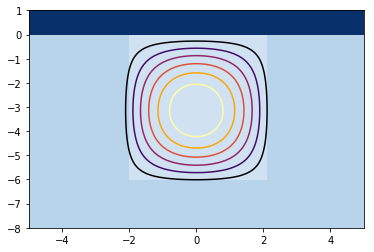

Effective Index = 2.1791559983100104


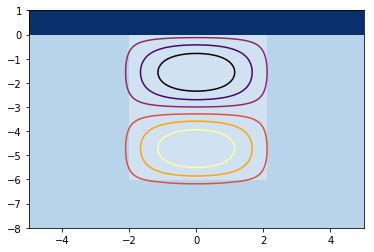

Effective Index = 2.17866755051312


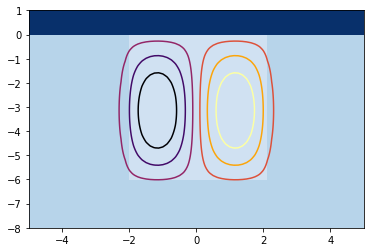

Effective Index = 2.178511363966389


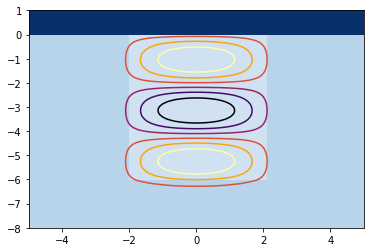

Effective Index = 2.1782799705311606


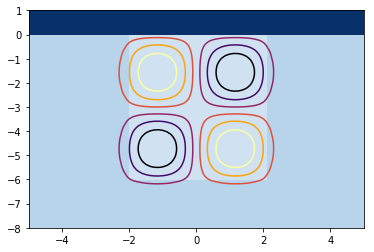

Effective Index = 2.177635540366082


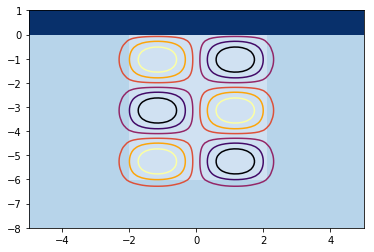

Effective Index = 2.1776122131402103


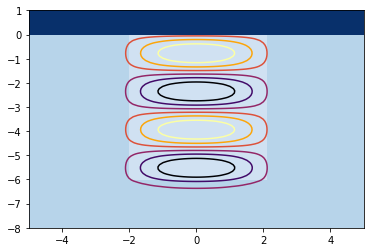

Effective Index = 2.177226788329542


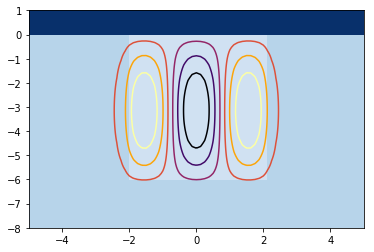

Effective Index = 2.1768394478557873


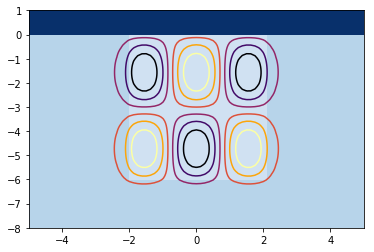

Effective Index = 2.176736740508001


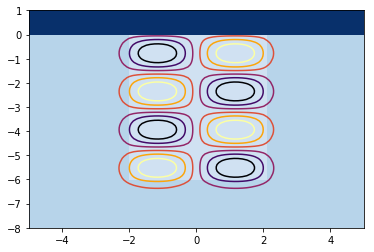

In [81]:
n_levels = 6  # Number of contour levels to use in plots

for i in range(neigs): # For each eigenvalue
    # Create a figure
    plt.figure()
    
    print('Effective Index = {}'.format(abs(beta[i] * lam / (2*cst.pi))))
    
    plt.pcolor(x,y,n[:,:,1], cmap = cm.Blues_r)
    plt.clim([2.1, 2.2])
    
    # Start a plot, find the contour levels, remove the zero level, replot without zero level
    plot_matrix = np.transpose(Ey_fields[i].real)
    levels = np.linspace(np.min(plot_matrix), np.max(plot_matrix), n_levels+2)
    c_plt = plt.contour(x, y, plot_matrix, cmap = cm.inferno, levels=levels)

    plt.show()

## Sweeping dispersion of beta, for a particular selected mode
Ok now we can pick a mode and sweep it over some range. This is a problem because the solver (like most solvers) requires a good guess for beta. 
To get round this we can run the above code for the wavelengths at either end of our range and fit a simple function such as and exponential to it. It might be nessary to solve for more modes than we need and post process the result. Let solve for the dispersion over the range $0.3\mu m$ to $1.\mu m$   

### Sweeping for a set of modes, including the one you're interested in
Ensure that the mode you're interested in will be included in the set you're solving for!

In [192]:
def n_guide(lam):
    A = 2.17954368571 
    B = np.log(2.17954368571 / 1.75292972992) / 0.7
    return A * np.exp(- B * (lam - 0.3))

steps = 5
neigs = 5
lams = np.linspace(0.3, 1., steps)
n_trial = n_guide(lams)

#Hopefully we can give it a bit more gas by passing a trial field 
E_in = np.concatenate((Ex[0], Ey[0]))
    
# Now we have a go sweeping 
beta_out = []
Ey_plot = []
Ex_plot = []

for i in range(steps):
    n = n_build(lams[i])
    k = 2. * cst.pi / lams[i] 
    P, _ = ps.eigen_build(k, n, dy, dx)
    
    # TODO: Fix complex casting warning
    beta, Ex , Ey = ps.solve.solve(   P, 
                                      2. * n_trial[i] * cst.pi / lams[i], 
                                      E_trial = E_in,  
                                      neigs = neigs  )
    
    Ey_plot.append([np.reshape(E_vec, (num_x, num_y)) for E_vec in Ey])
    Ex_plot.append([np.reshape(E_vec, (num_x, num_y)) for E_vec in Ex])
    beta_out.append(beta)


Assembling matrix for 8181 grid points...

and we are done (after 0.07004880905151367 secs).
Solving eigenmodes on CPU


c:\python36\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:725: ComplexWarning: Casting complex values to real discards the imaginary part
  self.info)


1.5254614353179932 secs later we have the final solution.
Assembling matrix for 8181 grid points...

and we are done (after 0.03759264945983887 secs).
Solving eigenmodes on CPU
3.1899046897888184 secs later we have the final solution.
Assembling matrix for 8181 grid points...

and we are done (after 0.07502555847167969 secs).
Solving eigenmodes on CPU
2.9948456287384033 secs later we have the final solution.
Assembling matrix for 8181 grid points...

and we are done (after 0.03767681121826172 secs).
Solving eigenmodes on CPU
2.3355164527893066 secs later we have the final solution.
Assembling matrix for 8181 grid points...

and we are done (after 0.03806257247924805 secs).
Solving eigenmodes on CPU
1.406162977218628 secs later we have the final solution.


### Post-processing, and selecting the desired mode
Ok so some of the modes will have changed position during the run so we need to do some post processing **to keep track of the index of the mode we are interested in.**

This works because of the orthogonality of the eigenmodes.

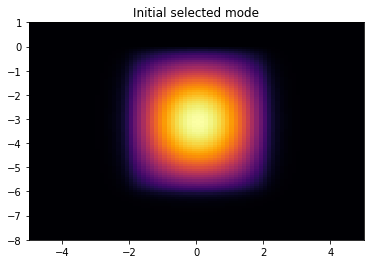

[0, 0, 0, 0]


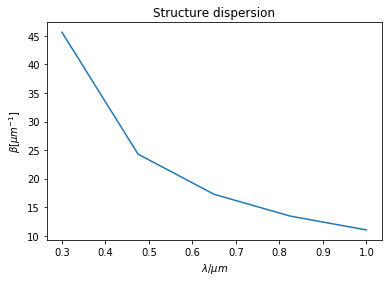

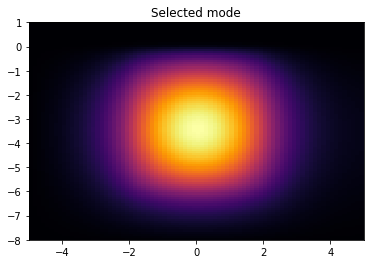

In [203]:
index = 0  # Select starting mode

# Initialise sweep trace arrays
beta_trace = [beta_out[0][index]]
Ey_plot_trace = [Ey_plot[0][index]]
Ex_plot_trace = [Ex_plot[0][index]]

E_trace = []  # New reordering method. WIP

# Plot selected mode for testing
plt.figure()
xend = np.size(x)
yend = np.size(y)
plt.pcolor(x, y, np.transpose(Ey_plot_trace[0].real), cmap = cm.inferno)
plt.title("Initial selected mode")
plt.show()

# Do sweep
indices = []  # Create an array to log the original position of the fundamental (just used for debugging)
for i in range(steps-1):
    # Takes product of all modes with all next modes the largest value should be the same mode!    
    prod_next = abs(np.einsum('kij, lij', Ey_plot[i], Ey_plot[i + 1]))
    
    E_trace.append(np.einsum('kij, kl', Ey_plot[i], prod_next))  # New reordering method. WIP
    
    index = np.argmax(prod_next[index, :])
    indices.append(index)  # Append the index, for debugging
    
    beta_trace.append(beta_out[i+1][index])
    Ey_plot_trace.append(Ey_plot[i+1][index])
    Ex_plot_trace.append(Ex_plot[i+1][index])
    
print(indices)  # Show indices, for debugging
    
# Now we can plot the dispersion and e field
plt.figure()
plt.plot(lams, np.real(beta_trace))
plt.xlabel('$\lambda / \mu m$')
plt.ylabel(r'$\beta [ \mu m^{-1} ]$')
plt.title("Structure dispersion")
plt.plot()
plt.show()

# Finally plot the mode at some sweep position 'some_random_point', for testing
plt.figure()
some_random_point = -1  # Last value in sweep
xend = np.size(x)
yend = np.size(y)
plt.pcolor(x, y, np.transpose(Ey_plot_trace[some_random_point].real), cmap = cm.inferno)
plt.title("Selected mode")
plt.show()

In [84]:
# Now you can save your data if you feel so inclined

import pickle 
from time import strftime

strftime("%d%b%Y_%H%M")
Array_pack = {
    #'Ex_polar': [betaEx_trace, Ex_plot_trace], 
    'Ey_polar': [betaEy_trace, Ey_plot_trace],
    'width'   : WG_width,
    'height'  : WG_height,
    'Lambda'  : lams   }


pickle.dump(Array_pack, open('KTP_dispersion_' +strftime("%d%b%Y_%H%M") + '.p', 'wb'))